In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


# Machine Learning

## Session 14d

### OpenVINO Tensorflow Model

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from openvino.runtime import Core

from IPython.display import Markdown, display

2023-07-13 10:23:25.907782: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 10:23:26.376177: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of inputs for this module
subDir = 'vino'

# set location of output files
outDir = os.path.join('..', 'output')

# set location of model files
modelDir = os.path.join('..', 'models')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 9),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.brg
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('bmh')

TEST_SIZE = 0.2

<Figure size 1500x900 with 0 Axes>

In [4]:
base_model_dir = os.path.join(modelDir, 'flower_photos')# expand the path as per the os and environment

model_name = "dropout_bn_no_bias_swish_flowers"
model_name = f'{model_name}.h5'
model_path = os.path.join(base_model_dir, model_name)

In [5]:
## Load model
model = tf.keras.models.load_model(model_path)

model.summary()

2023-07-13 10:23:27.133315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-13 10:23:27.172854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-13 10:23:27.173043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 188, 188, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 188, 188, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 188, 188, 3)       0         
 otation)                                                        
                                                                 
 conv2d (Conv2D)             (None, 188, 188, 64)      1728      
                                                                 
 batch_normalization (Batch  (None, 188, 188, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 188, 188, 64)      0

In [6]:
tf.saved_model.save(model,base_model_dir)

INFO:tensorflow:Assets written to: ../models/flower_photos/assets


INFO:tensorflow:Assets written to: ../models/flower_photos/assets


In [7]:
print(model.layers[0].name, model.layers[0].get_input_shape_at(0))
print(model.layers[-1].name, model.layers[-1].get_output_at(0).name)

rescaling (None, 188, 188, 3)
dense_1 dense_1/BiasAdd:0


In [8]:
# Construct the command for Model Optimizer.
mo_command = f'mo --saved_model_dir ../models/flower_photos/  --input_shape=\[1,188,188,3\]'
                 
mo_command = " ".join(mo_command.split())

print("Model Optimizer command to convert the ONNX model to OpenVINO:")
display(Markdown(f"`{mo_command}`"))

Model Optimizer command to convert the ONNX model to OpenVINO:


`mo --saved_model_dir ../models/flower_photos/ --input_shape=\[1,188,188,3\]`

In [9]:
mo_result = %sx $mo_command
print("\n".join(mo_result))

[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai/2023.0/openvino_2_0_transition_guide.html
[ INFO ] IR generated by new TensorFlow Frontend is compatible only with API v2.0. Please make sure to use API v2.0.
Find more information about new TensorFlow Frontend at https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_TensorFlow_Frontend.html
[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /home/pks/01_projects/CDAC/DHPCAP_Mar2023/notebooks/saved_model.xml
[ SUCCESS ] BIN file: /home/pks/01_projects/CDAC/DHPCAP_Mar2023/notebooks/saved_model.bin


In [10]:
ie = Core()

model = ie.read_model(model='saved_model.xml')
compiled_model = ie.compile_model(model=model, device_name='CPU')

input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output('dense_1')

In [11]:
input_layer_ir, output_layer_ir

(<ConstOutput: names[rescaling_input] shape[1,188,188,3] type: f32>,
 <ConstOutput: names[dense_1] shape[1,5] type: f32>)

## Load an Image

In [12]:
# Text detection models expect an image in BGR format.
image = cv2.imread(filename=os.path.join(inpDir,'flower_photos/roses/15277801151_5ed88f40f0_n.jpg'))

image.shape

(248, 320, 3)

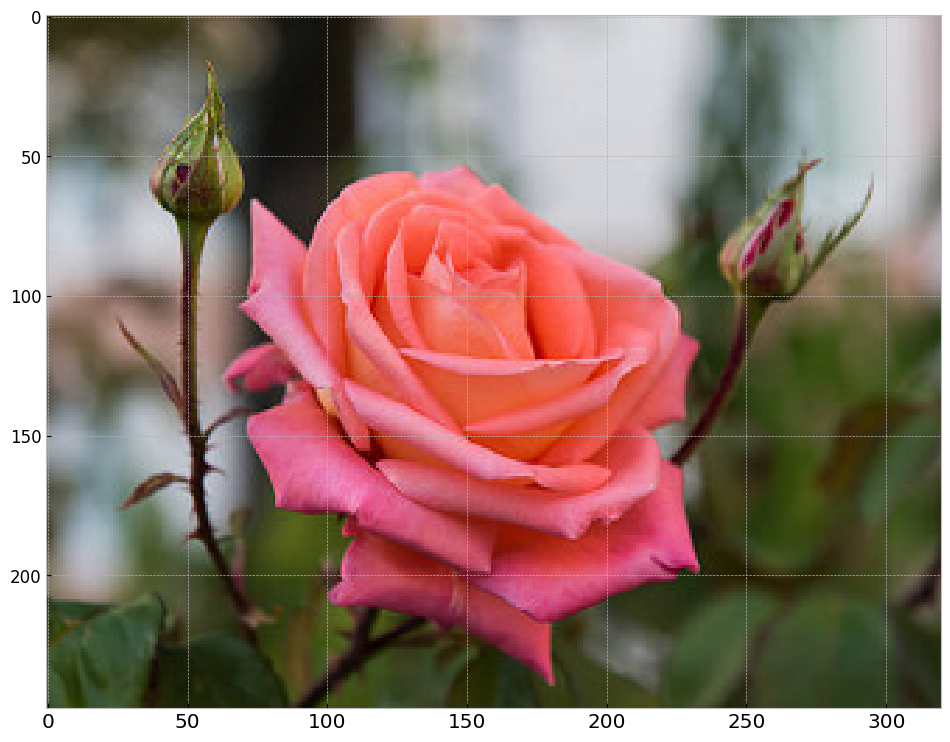

In [13]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

In [14]:
input_layer_ir.shape

<Shape: [1,188,188,3]>

In [15]:
# N,C,H,W = batch size, number of channels, height, width.
N, H, W, C  = input_layer_ir.shape
N, H, W, C

(1, 188, 188, 3)

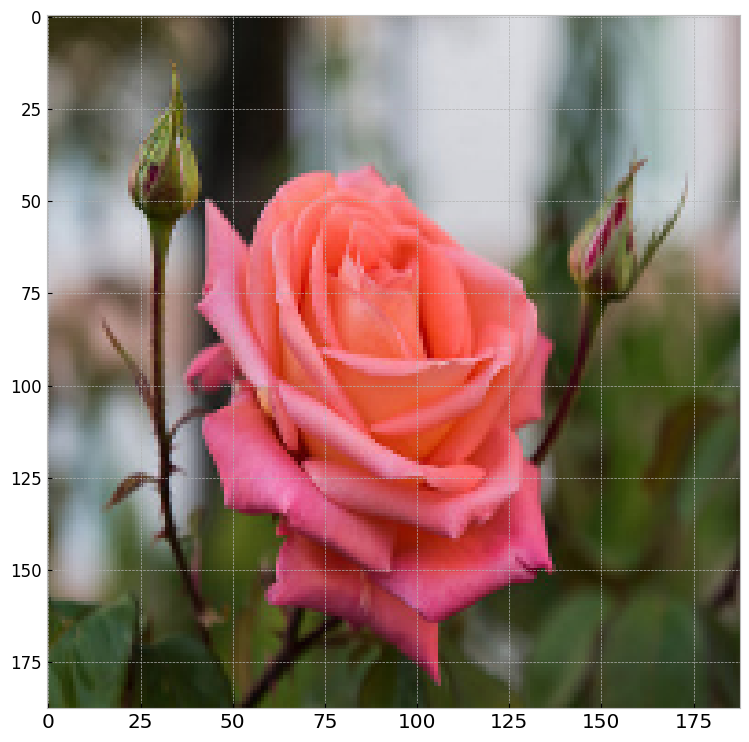

In [16]:
# Resize the image to meet network expected input sizes.
resized_image = cv2.resize(image, (W, H))
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB));

In [17]:
input_image = np.expand_dims(resized_image, 0)
input_image.shape

(1, 188, 188, 3)

## Inference

In [18]:
# Create an inference request.
y_pred = compiled_model([input_image])[output_layer_ir]
y_pred

array([[-0.35795698,  0.03842422,  0.64785826, -1.376908  ,  0.5383404 ]],
      dtype=float32)

In [19]:
y_pred.argmax()

2

In [20]:
flower_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
res = flower_names[y_pred.argmax()]
res

'roses'